# ZIKA CLASSIFICATION MODEL

## IMPORTS

In [32]:
# Algorithms
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.metrics import classification_report, precision_recall_curve

# Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.decomposition import TruncatedSVD
from modules.transformers import *

# Visuals
# from modules.custom_plot import plot_confusion_matrix
import matplotlib.pyplot as plt
% matplotlib inline

# Miscellaneous
from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np
import pickle

## LOAD DATA

In [2]:
df = pd.read_csv('data/161207_ZikaLabels.csv')
df.dropna(axis=0,inplace=True) #drop NaNs or else NaNs would confuse the algorithms
X = df.diagnosisRAW
y = df.zika
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [71]:
class_mapping = {label:indx for indx,label in enumerate(np.unique(df.zika))}
encoded_y_test = y_test.map(class_mapping)
N = float(len(encoded_y_test[encoded_y_test==0]))
P = float(len(encoded_y_test[encoded_y_test==1]))
baseline_PR = P/(P+N)

## ALGORITHMS

In [26]:
algorithms = {}
algorithms['Gradient_Boost'] = GradientBoostingClassifier(random_state=42)
algorithms['Logistic_Regression'] = LogisticRegression(random_state=42)
algorithms['Random_Forest'] = RandomForestClassifier(random_state=42)
algorithms['Gauss_Naive_Bayes'] = GaussianNB()

## TRAIN MODELS

In [72]:
# Latent Semantic Analysis (LSA)
lsa = make_pipeline(TfidfVectorizer(),TruncatedSVD(n_components=500)) 
# n_components = 100-500 is the general range for LSA applications and depends on size of corpus
# https://medium.com/@adi_enasoaie/easy-lsi-pipeline-using-scikit-learn-a073f2484408#.j50q4rwnz

# Feature Extractions
feature_union = make_union(lsa,ZikaCounterTransformer(), SentimentTransformer()) 

###################################################################################################################
	 	 MODEL:Logistic_Regression 	 ACCURACY:0.929133858268 	 AUC:0.502879332617
###################################################################################################################
             precision    recall  f1-score   support

      False       0.93      1.00      0.96      1298
       True       0.00      0.00      0.00        99

avg / total       0.86      0.93      0.90      1397



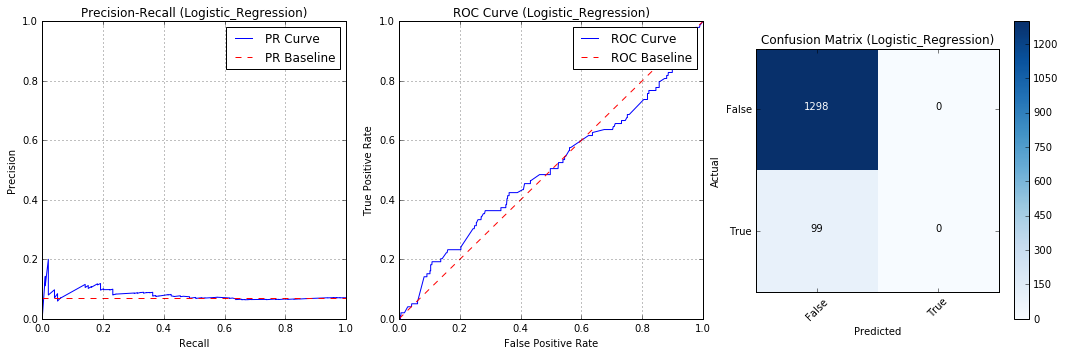


###################################################################################################################
	 	 MODEL:Gradient_Boost 	 ACCURACY:0.926270579814 	 AUC:0.516287684238
###################################################################################################################
             precision    recall  f1-score   support

      False       0.93      1.00      0.96      1298
       True       0.25      0.02      0.04        99

avg / total       0.88      0.93      0.90      1397



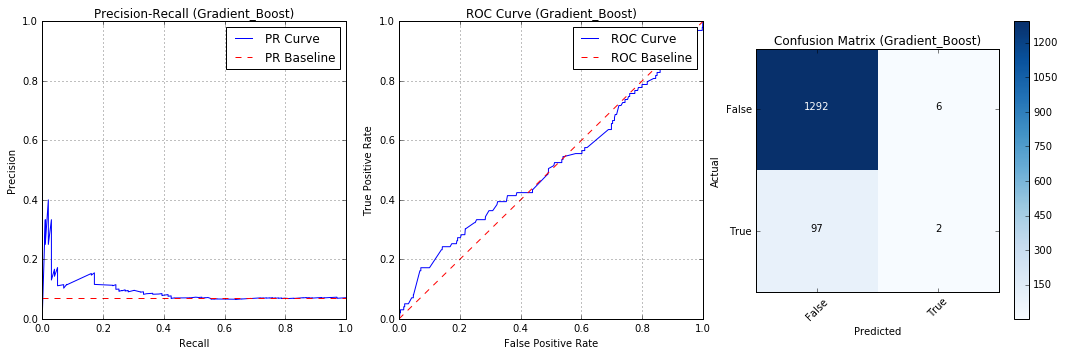


###################################################################################################################
	 	 MODEL:Gauss_Naive_Bayes 	 ACCURACY:0.307802433787 	 AUC:0.464113399013
###################################################################################################################
             precision    recall  f1-score   support

      False       0.91      0.28      0.43      1298
       True       0.07      0.66      0.12        99

avg / total       0.85      0.31      0.41      1397



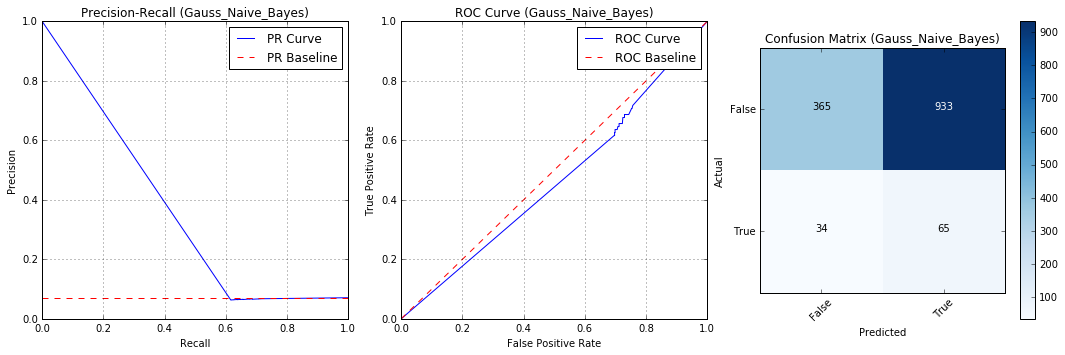


###################################################################################################################
	 	 MODEL:Random_Forest 	 ACCURACY:0.926270579814 	 AUC:0.477307746183
###################################################################################################################
             precision    recall  f1-score   support

      False       0.93      1.00      0.96      1298
       True       0.17      0.01      0.02        99

avg / total       0.88      0.93      0.89      1397



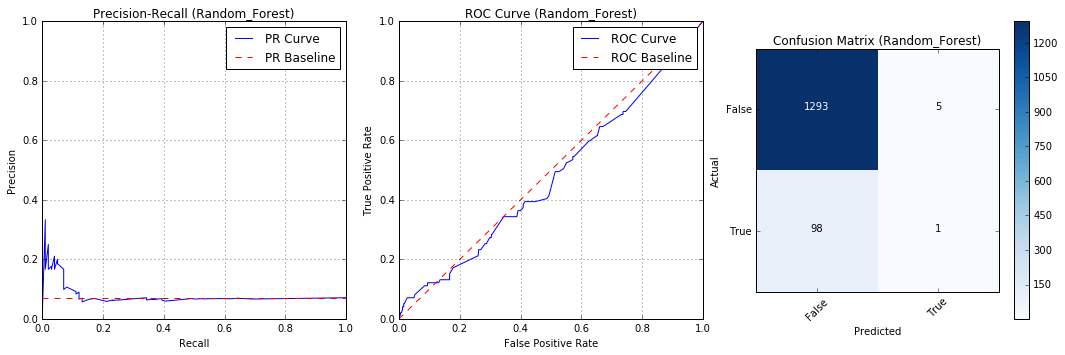

In [105]:
for name,algorithm in algorithms.items():
    # Data Pipeline
    pipeline = make_pipeline(AsciiTransformer(),
                            LowerCaseTransformer(),
                            RemoveSymsTransformer(),
                            RemoveStopWordsTransformer(),
                            feature_union,
                            algorithm)
    # Train Model
    model = pipeline.fit(X_train,y_train)
    
    # Make Predictions
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)
 
    # Metrics (for model evaluation)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    score = accuracy_score(y_test,y_pred) # accuracy = (correct preds)/(num samples) = (TP+TN)/(TP+TN+FP+FN)
    precision,recall,threshold_PR = precision_recall_curve(encoded_y_test,y_pred_probs[:,1],pos_label=1)
    fpr,tpr,threshold_ROC = roc_curve(encoded_y_test,y_pred_probs[:,1],pos_label=1)
    AUC = auc(fpr,tpr)
    print '#'*115
    print '\t \t MODEL:{} \t ACCURACY:{} \t AUC:{}'.format(name, score, AUC)
    print '#'*115    
    print classification_report(y_test,y_pred)
    
    # Plot Figures
    fig,axs = plt.subplots(nrows=1,ncols=3)
    fig.set_figwidth(15)
    fig.set_figheight(5)
    # PR Curve
    ax = axs[0]
    ax.plot(recall,precision)
    ax.plot(np.linspace(0,1,len(recall)),[baseline_PR]*len(recall),'--r')
    ax.set_title('Precision-Recall ({})'.format(name))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(['PR Curve','PR Baseline'])
    ax.grid(True)
    # ROC Curve
    ax = axs[1]
    ax.plot(fpr,tpr)
    ax.plot(np.linspace(0,1,len(fpr)),np.linspace(0,1,len(fpr)),'--r')
    ax.set_title('ROC Curve ({})'.format(name))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(['ROC Curve','ROC Baseline'])
    ax.grid(True)
    # Plot Confusion Matrix
    ax = axs[2]
    class_names = sorted(df.zika.unique())
    plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion Matrix ({})'.format(name) )
    plt.show()
    print 

## OPTIMIZE N_components

SCORE, AUC, TPr & TNr

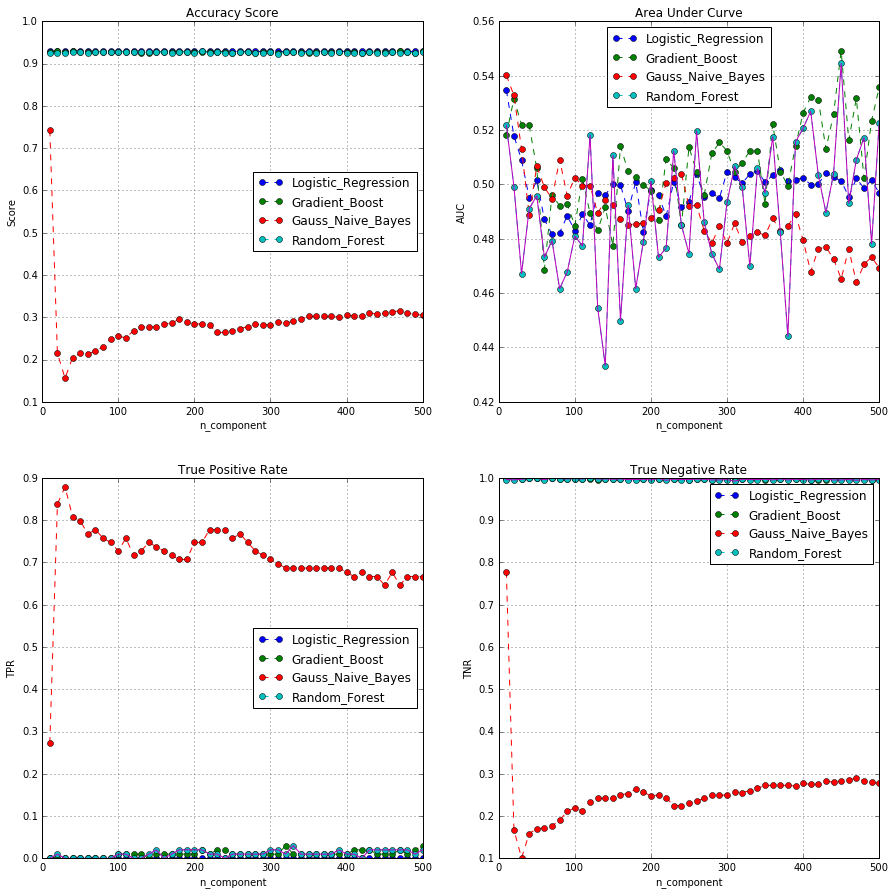

In [116]:
# Initiate Figures
fig,axs = plt.subplots(nrows=2,ncols=2)
fig.set_figwidth(15)
fig.set_figheight(15)
labels = [] # model names

for name,algorithm in algorithms.items():
    labels.append(name)
    scores = [] # accuracy score = (TP+TN)/(TP+TN+FP+FN)
    aucs = [] # area under ROC curve
    tprs = [] # true positive rate = sensitivity = TP/P = TP/(TP+FN)
    tnrs = [] # true negative rate = specificity = TN/N = TN/(TN+FP)
    n_components = [] # number of principal components
    for n in range(10,501,10):
        # Data Pipeline
        lsa = make_pipeline(TfidfVectorizer(),TruncatedSVD(n_components=n))
        feature_union = make_union(lsa,ZikaCounterTransformer(), SentimentTransformer()) 
        pipeline = make_pipeline(AsciiTransformer(),
                                LowerCaseTransformer(),
                                RemoveSymsTransformer(),
                                RemoveStopWordsTransformer(),
                                feature_union,
                                algorithm)
        # Train Model
        model = pipeline.fit(X_train,y_train)

        # Make Predictions
        y_pred = model.predict(X_test)
        y_pred_probs = model.predict_proba(X_test)

        # Metrics (for model evaluation)
        score = accuracy_score(y_test,y_pred) # accuracy = (correct preds)/(num samples) = (TP+TN)/(TP+TN+FP+FN)
        precision,recall,threshold_PR = precision_recall_curve(encoded_y_test,y_pred_probs[:,1],pos_label=1)
        fpr,tpr,threshold_ROC = roc_curve(encoded_y_test,y_pred_probs[:,1],pos_label=1)
        AUC = auc(fpr,tpr)
        cnf_matrix = confusion_matrix(y_test, y_pred)
        TP = float(cnf_matrix[1][1])
        FN = float(cnf_matrix[1][0])
        TN = float(cnf_matrix[0][0])
        FP = float(cnf_matrix[0][1])
        TPR = TP/(TP+FN)
        TNR = TN/(TN+FP) 
        
        # Save Data
        scores.append(score)
        aucs.append(AUC)
        tprs.append(TPR)
        tnrs.append(TNR)
        n_components.append(n)
    
    ax = axs[0,0]
    ax.plot(n_components,scores,'--o')
    ax = axs[0,1]
    ax.plot(n_components,aucs,'--o')
    ax = axs[1,0]
    ax.plot(n_components,tprs,'--o')
    ax = axs[1,1]
    ax.plot(n_components,tnrs,'--o')

# Scores VS n_components
ax = axs[0,0]
ax.set_title('Accuracy Score')
ax.set_xlabel('n_component')
ax.set_ylabel('Score')
ax.legend(labels, loc='best')
ax.grid(True)
# AUCs VS n_components
ax = axs[0,1]
ax.plot(n_components,aucs)
ax.set_title('Area Under Curve')
ax.set_xlabel('n_component')
ax.set_ylabel('AUC')
ax.legend(labels, loc='best')
ax.grid(True)
# True Positive Rate VS n_components
ax = axs[1,0]
ax.plot(n_components,tprs)
ax.set_title('True Positive Rate')
ax.set_xlabel('n_component')
ax.set_ylabel('TPR')
ax.legend(labels, loc='best')
ax.grid(True)
# True Negative Rate VS n_components
ax = axs[1,1]
ax.plot(n_components,tnrs)
ax.set_title('True Negative Rate')
ax.set_xlabel('n_component')
ax.set_ylabel('TNR')
ax.legend(labels, loc='best')
ax.grid(True)

## SAVE MODELS

In [117]:
for name,algorithm in algorithms.items():
    lsa = make_pipeline(TfidfVectorizer(),TruncatedSVD(n_components=500))
    feature_union = make_union(lsa,ZikaCounterTransformer(), SentimentTransformer()) 
    pipeline = make_pipeline(AsciiTransformer(),
                            LowerCaseTransformer(),
                            RemoveSymsTransformer(),
                            RemoveStopWordsTransformer(),
                            feature_union,
                            algorithm)
    model = pipeline.fit(X_train,y_train)
    with open('models/MODEL_{}.plk'.format(name),'wb') as f:
        pickle.dump(model,f)

In [ ]:
def test_run_model(text):
    print 'Text input: \"{}\"'.format(text)
    print 'Prediction: {}'.format(pipe.predict(pd.Series(text))[0])
    print 'Probability the model thinks you do NOT have the Zika Virus (FALSE): {}'.format(pipe.predict_proba(pd.Series(text))[0][0],4)
    print 'Probability the model thinks you DO have the Zika Virus (TRUE): {}'.format(pipe.predict_proba(pd.Series(text))[0][1],4)
    
text = 'Eu tenho o vírus zika' #I have the zika virus
text = 'Eu nao tenho o virus zika' # I do not have the zika virus




## ANALYSIS

From the two examples above, the model we can obviously see the model cannot differentiate between whether someone has Zika or not based off of that person's text message.

So, why is that? I have spent some time thinking about whether or not it is possible. One method that I have chosen to determine whether there is "distinction" or semantic group for text related to people with Zika or not is... a word2vec (word to vectors) model approach visualized via TNSE, a method that allows you to visualize high dimensionality space.

Check out the Word2Vec_model.ipynb to see my semantic grouping of words. Just a forewarning, this is no semantic grouping...at least from my perspective.

## TEST RUN

In [31]:
with open('Naive_Bayes_MODEL2.plk','rb') as f:
    pipe = pickle.load(f)
text = 'Eu tenho o virus zika'
print 'TEXT_INPUT: \"{}\"'.format(text)
print 'PREDICTION: {}'.format(pipe.predict(pd.Series(text))[0])
print 'FALSE_PROB: {} \t TRUE_PROB: {}'.format(pipe.predict_proba(pd.Series(text))[0][0],
                                               pipe.predict_proba(pd.Series(text))[0][1])

#     print 'Prediction:', model.predict('eu tenho o virus zika')
#     print 'Score:', model.score(X_test,y_test)

TEXT_INPUT: "Eu tenho o virus zika"
PREDICTION: True
FALSE_PROB: 1.81933899917e-05 	 TRUE_PROB: 0.99998180661
